#### Import relevant Libraries

In [296]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer, MinMaxScaler, StandardScaler, RobustScaler
from progress.bar import Bar
%matplotlib inline

#### Import Dataset

In [2]:
columns1=['age','workclass','fnlwgt','education','education_num','marital_status','occupation','relationship','race','sex','capital_gain','capital_loss','hours_per_week','native_country','sal']

In [3]:
raw_df=pd.read_csv('adult.data',names=columns1)

In [4]:
raw_df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,sal
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
raw_df['native_country'] = raw_df['native_country'].str.strip()

In [6]:
#slicing dataset for native_country is united states
usa_df=raw_df[raw_df['native_country']=='United-States']

In [61]:
#slicing dataset for native_country is  not united states
other_df=raw_df[raw_df['native_country']!='United-States']

#### Data Analysis

In [7]:
usa_df.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,29170.000000,2.917000e+04,29170.000000,29170.000000,29170.000000,29170.000000
mean,38.655674,1.870690e+05,10.169455,1089.229928,88.510593,40.447755
std,13.722408,1.048780e+05,2.394966,7381.898528,405.681709,12.417203
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.158952e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.767300e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.341385e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


#### Summary Statistics of Numerical Attributes
    For Age
1. The value of Age attribute ranges from 17 to 90
2. The 1st quartile implies 25% of the observations lies below 28.
3. 3rd quartile shows that in 75% of the observations the value of age is less than 48.
4. The difference between mean & median is not that much high but the difference between 3rd quartile & maximum made the distribution is left skewed.

   For Hours per week :
1. The value of hours per week ranges from 1 to 99 hours
2. mean value of hours per week is 40 hours per week
3. Using quartiles we can say that data is approximately symmetric.
4. Person spending 99 working hours per week are very rare events.

   For capital loss and capital gain we can say they are almost similar attributes. mostly concentrated on zero(about 75%) or on very high value.

In [64]:
usa_df.shape

(29170, 15)

#### Target Variable Class

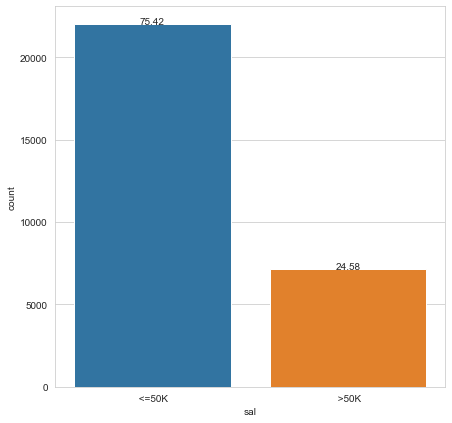

In [66]:
plt.figure(figsize=(7,7))
total = float(len(usa_df) )

ax = sns.countplot(x="sal", data=usa_df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format((height/total)*100),
            ha="center") 
plt.show()

#### percentage of People earning sal >50K is around 25 % and for other group is 75 %.Our predictor classe is imbalanced.


In [9]:
usa_df.groupby('sal').mean()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
sal,,,,,,
<=50K,36.816719,186950.05173,9.710032,151.071549,53.972635,38.799127
>50K,44.297169,187433.99233,11.578859,3967.286850,194.465207,45.505369


#### we can observe that people earning more than 50K are more aged, highly educated and are working for longer time in compare to other group

In [276]:
df=usa_df.copy()#copying dataset to df

In [277]:
df.drop('native_country',axis=1,inplace=True)#There is no need for native_country as this whole dataset belons to USA

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29170 entries, 0 to 32560
Data columns (total 14 columns):
age               29170 non-null int64
workclass         29170 non-null object
fnlwgt            29170 non-null int64
education         29170 non-null object
education_num     29170 non-null int64
marital_status    29170 non-null object
occupation        29170 non-null object
relationship      29170 non-null object
race              29170 non-null object
sex               29170 non-null object
capital_gain      29170 non-null int64
capital_loss      29170 non-null int64
hours_per_week    29170 non-null int64
sal               29170 non-null object
dtypes: int64(6), object(8)
memory usage: 3.3+ MB


In [13]:
#COUNT for capital_gain as mostly of it is zero
(df['capital_gain']==0).value_counts()

True     26699
False     2471
Name: capital_gain, dtype: int64

In [14]:
(df['capital_loss']==0).value_counts()#for capital_loss column

True     27791
False     1379
Name: capital_loss, dtype: int64

#### We can see 90 % of value is zero for both variables so we can drop it. In addition, we can also drop finalwgt and education_num as finalwgt depends on demographics and education_num is irrelevant as we already have education variable in dataset.

In [278]:
df.drop(['capital_gain','capital_loss','education_num','fnlwgt'],axis=1,inplace=True)

#### Data Visualization

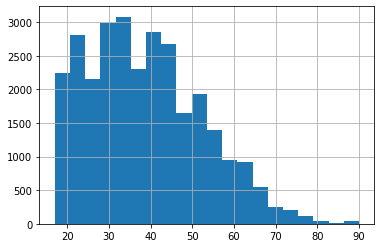

In [16]:
df['age'].hist(bins=20)

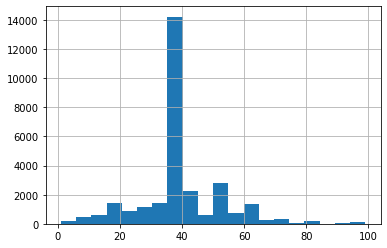

In [17]:
df['hours_per_week'].hist(bins=20)

In [279]:

df = pd.get_dummies(df,columns=['sal'],drop_first=True)


In [280]:
df.head()

,age,workclass,education,marital_status,occupation,relationship,race,sex,hours_per_week,sal_ >50K
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,40,0
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,0
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,0
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,0
5,37,Private,Masters,Married-civ-spouse,Exec-managerial,Wife,White,Female,40,0


#### Salary vs Education Plot

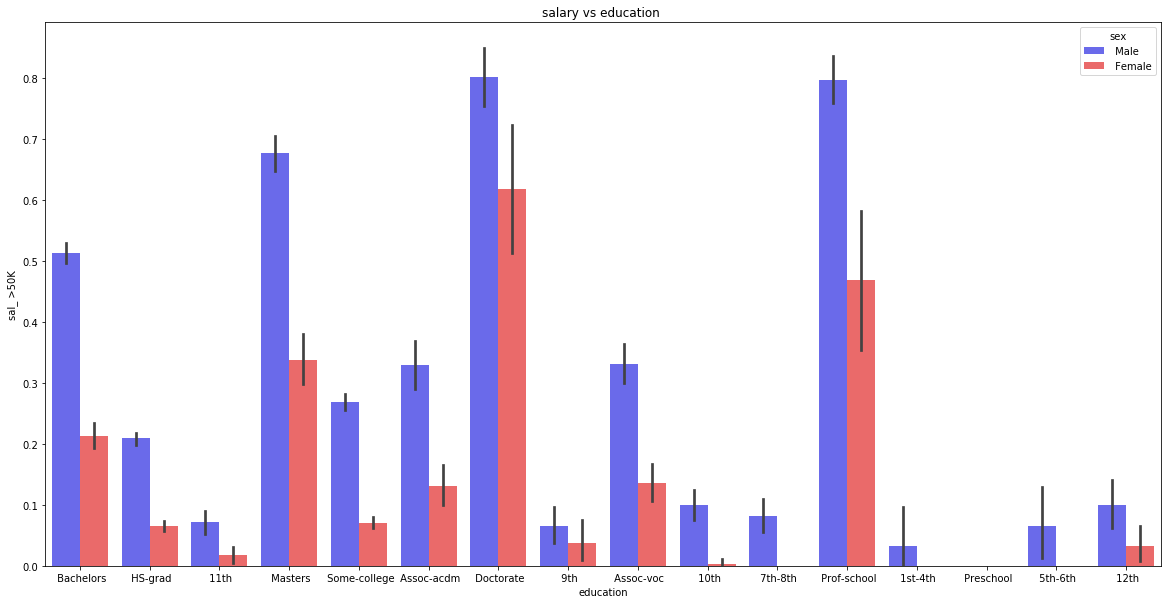

In [20]:
plt.figure(figsize=(20,10))
plt.title('salary vs education ')
sns.barplot(x='education',y='sal_ >50K',data=df,hue='sex',palette='seismic')

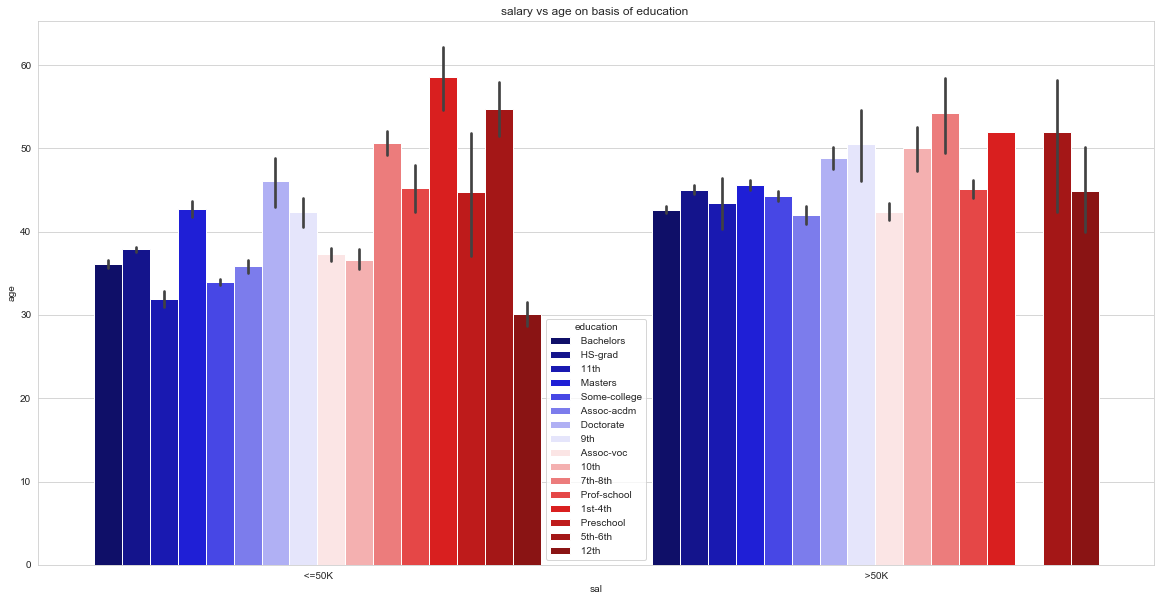

In [166]:
plt.figure(figsize=(20,10))
plt.title('salary vs age on basis of education ')
sns.barplot(x='sal',y='age',data=usa_df,hue='education',palette='seismic')

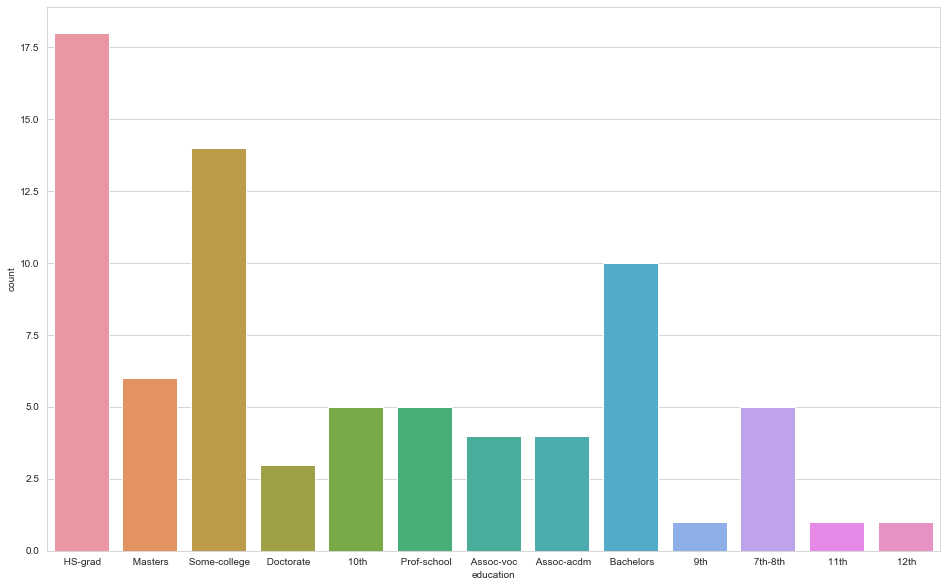

In [200]:
### checking values for  where  hours_per_week are 99
plt.figure(figsize=(16,10))

usa=usa_df[usa_df['hours_per_week']==99]
sns.countplot(x='education',data=usa)


In [201]:
usa_df[(usa_df['education'].str.strip()=='10th')]['occupation'].unique()

array([' ?', ' Craft-repair', ' Other-service', ' Adm-clerical',
       ' Farming-fishing', ' Handlers-cleaners', ' Transport-moving',
       ' Exec-managerial', ' Machine-op-inspct', ' Sales',
       ' Protective-serv', ' Priv-house-serv', ' Tech-support',
       ' Prof-specialty'], dtype=object)

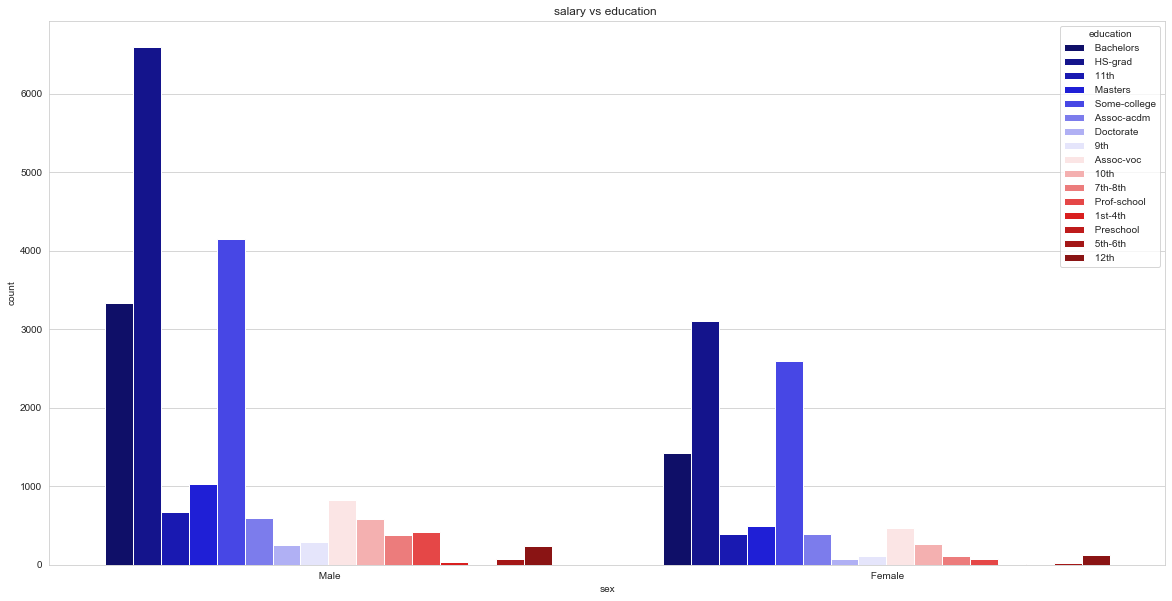

In [149]:
plt.figure(figsize=(20,10))
plt.title('salary vs education ')
sns.countplot(x='sex',data=usa_df,hue='education',palette='seismic')

#### Most of the people in working class are just HS graduated next most found degree is Bachelors.

 #### Salary vs Occupation type Plot


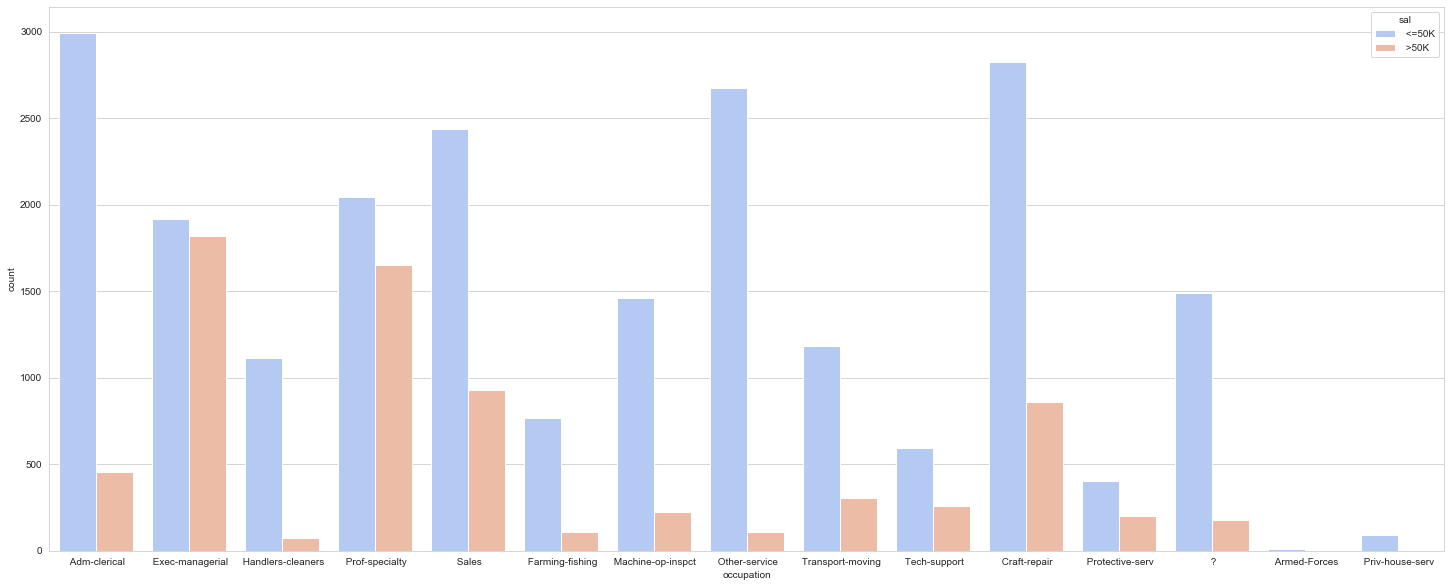

In [204]:
plt.figure(figsize=(25,10))
sns.countplot(x='occupation',data=usa_df,hue='sal',palette='coolwarm')

#### Salary vs Marital Status Plot

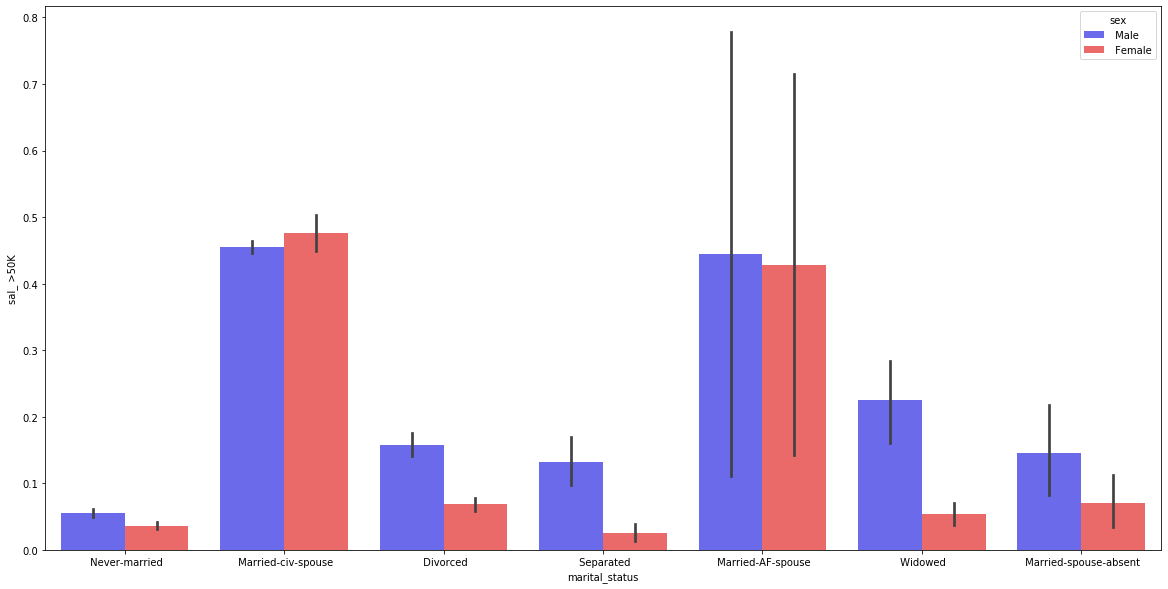

In [22]:
plt.figure(figsize=(20,10))
sns.barplot(x='marital_status',y='sal_ >50K',data=df,hue='sex',palette="seismic")

#### Salary vs Gender Plot

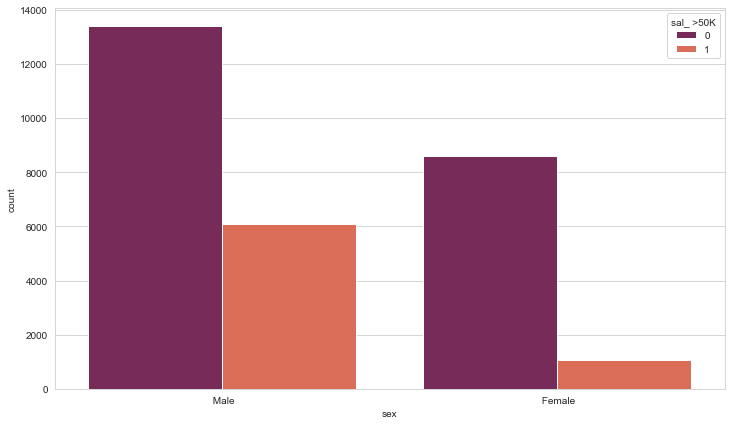

In [23]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,7))
sns.countplot(x='sex',hue='sal_ >50K',data=df,palette='rocket')

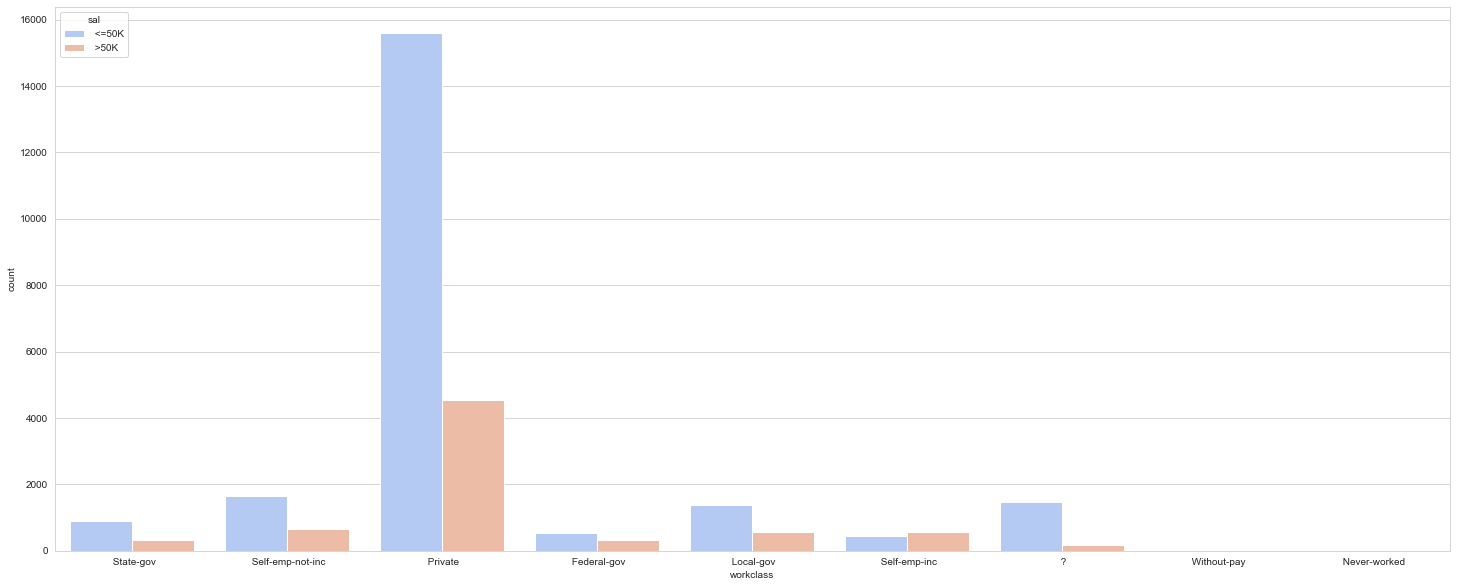

In [113]:
plt.figure(figsize=(25,10))
sns.countplot(x='workclass',data=usa_df,hue='sal',palette='coolwarm')

#### Most of the population is working in private sector

#### Encoding categorical variable

In [281]:
cat_feats=['workclass','education','marital_status','occupation','relationship','race','sex']
df = pd.get_dummies(df,columns=cat_feats,drop_first=True)

#### Checking Correlation

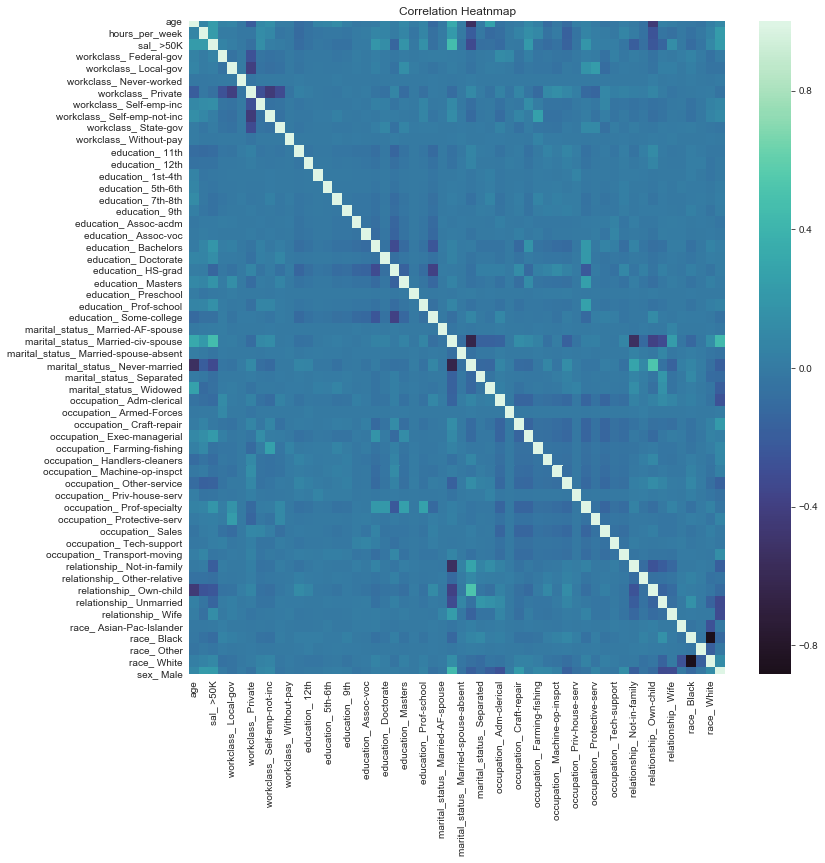

In [25]:
plt.figure(figsize=(12,12))
plt.title("Correlation Heatnmap")
sns.heatmap(df.corr(), center=0,cmap='mako')

#### there no strong correlation was found between predictor variables as positive or negative  and our predictor variables are as follows
        1. age 
        2. hours_per_week
        3. race
        4. education
        5. occupation
        6. marital_status
        7. work_class
        8. sex(male/female)

#### Train Test Split

In [282]:
#partitioning predictor and target variable
y=df['sal_ >50K']
X=df.drop(['sal_ >50K'],axis=1)
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


#### Standardizing Variable

In [283]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# num_cols=['age','hours_per_week']
# # df_num = pd.DataFrame(scaler.fit_transform(df[num_cols]),columns= num_cols)
# # df=pd.merge(df_num,df)

X_train = pd.DataFrame(scaler.fit_transform(X_train))

X_test = pd.DataFrame(scaler.transform(X_test))


#### Create Baseline model
    We selected simple logistic regression as baseline model and AUC(area under curve) as metric to compare different model"s performances

In [284]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc

In [285]:
logreg=LogisticRegression()
logreg.fit(X_train,y_train)
predict = logreg.predict(X_train)

In [286]:
# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train,predict)
roc_auc = auc(false_positive_rate,true_positive_rate)
print('\nAUC is :{0}'.format(round(roc_auc, 2)))


AUC is :0.74


### PCA

In [287]:
from sklearn.decomposition import PCA
pca = PCA()
X_train = pca.fit_transform(X_train)
print(pca.explained_variance_ratio_)

[6.02636619e-02 4.05466940e-02 3.76923089e-02 3.15106126e-02
 2.89533879e-02 2.83251981e-02 2.59551004e-02 2.47963680e-02
 2.36575496e-02 2.30627354e-02 2.22818866e-02 2.15498672e-02
 2.11513705e-02 2.07254564e-02 2.03931002e-02 2.02792234e-02
 1.98178198e-02 1.95300990e-02 1.94777247e-02 1.93068848e-02
 1.90885829e-02 1.89860509e-02 1.87502306e-02 1.87149258e-02
 1.86512203e-02 1.85623374e-02 1.84361138e-02 1.82822464e-02
 1.81055038e-02 1.80894155e-02 1.79834287e-02 1.79363629e-02
 1.77891208e-02 1.76818796e-02 1.74283785e-02 1.73591648e-02
 1.69869560e-02 1.68775072e-02 1.67932773e-02 1.58722323e-02
 1.56589558e-02 1.44774262e-02 1.43219394e-02 1.33647766e-02
 1.19232840e-02 1.17235050e-02 8.26124630e-03 7.98778279e-03
 6.27469855e-03 3.73727580e-03 3.01977642e-03 8.26987199e-04
 6.29835566e-04 1.40525398e-04 1.18849117e-32]


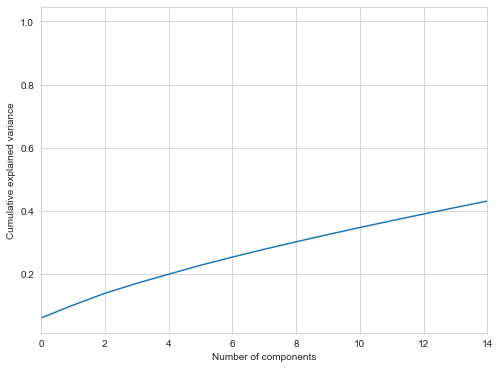

In [288]:
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,14,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

### Logistic Regression with PCA

In [33]:
# from sklearn.pipeline import Pipeline
# # Construct some pipelines
# pipe_lr = Pipeline([('pca', PCA(n_components=14, random_state=123)),
#          ('clf', LogisticRegression(random_state=123))])

# # Fit the pipelines
# pipe_lr.fit(X_train, y_train)

In [34]:
# predict = pipe_lr.predict(X_train)



In [35]:
# # Check the AUC for predictions
# false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train,predict)
# roc_auc = auc(false_positive_rate,true_positive_rate)
# print('\nAUC is :{0}'.format(round(roc_auc, 2)))

#### SMOTE

In [289]:
from imblearn.over_sampling import SMOTE

# Previous original class distribution
print(y_train.value_counts()) 

# Fit SMOTE to training data
X_train_resampled, y_train_resampled = SMOTE().fit_sample(X_train, y_train) 

# Preview synthetic sample class distribution
print('\n')
print(pd.Series(y_train_resampled).value_counts()) 

0    17596
1     5740
Name: sal_ >50K, dtype: int64


1    17596
0    17596
Name: sal_ >50K, dtype: int64


In [290]:
#fit the model
model_log = logreg.fit(X_train_resampled, y_train_resampled)

#predict with model

predict_smote = logreg.predict(X_train_resampled)

# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_resampled,predict_smote)
roc_auc = auc(false_positive_rate,true_positive_rate)
print('\nAUC is :{0}'.format(round(roc_auc, 2)))


AUC is :0.81


#### Create a pipeline consisting of a linear SVM, a simple Decision Tree and a simple Random Forest Classifier

In [291]:
from sklearn.pipeline import Pipeline
from sklearn import svm,tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, roc_curve, auc

## KEEP IT FOR NOW
# Construct some pipelines
pipe_svm = Pipeline([('pca', PCA(n_components=2)),
        ('clf', svm.SVC(random_state=123))])
        
pipe_tree = Pipeline([('pca', PCA(n_components=2)),
        ('clf', tree.DecisionTreeClassifier(random_state=123,class_weight="balanced"))])

pipe_rf = Pipeline([('pca', PCA(n_components=2)),
        ('clf', RandomForestClassifier(random_state=123,class_weight="balanced"))])

# List of pipelines, List of pipeline names
pipelines = [pipe_svm, pipe_tree, pipe_rf]
pipeline_names = ['Support Vector Machine','Decision Tree','Random Forest']



# Loop to fit each of the three pipelines
for pipe in pipelines:
    print(pipe)
    pipe.fit(X_train, y_train)
    
# Loop to predict each of the three pipelines
for pipe in pipelines:
    pipe.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train,pipe.predict(X_train))
    roc_auc = auc(false_positive_rate,true_positive_rate)
    print('\nAUC is :{0}'.format(round(roc_auc, 2)))


# Compare accuracies
for index, val in enumerate(pipelines):
    print('%s pipeline train accuracy: %.3f' % (pipeline_names[index], val.score(X_train, y_train)))



Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=2,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('clf',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=123, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)
Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=2,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('clf',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced',
                                        criterion='gini', max_d

#### KNN with grid search

In [342]:
from sklearn.neighbors import KNeighborsClassifier

In [343]:
knn= KNeighborsClassifier()

In [360]:
knn.fit(X_train,y_train)
from sklearn.model_selection import GridSearchCV
k_range = list(range(1,20))
weight_options = ["uniform", "distance"]
m=['euclidean','manhattan']
param_grid = dict(n_neighbors=k_range)
gs= GridSearchCV(KNeighborsClassifier(),param_grid,verbose=True,scoring='roc_auc')
# Fit to the data
gs.fit(X_train, y_train)
print(f"Mean Cross Validation Score: {mean_dt_cv_score :.2%}")
# Predict to the data
predict = gs.predict_proba(X_train)
# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train,predict[:,1])
roc_auc = auc(false_positive_rate,true_positive_rate)
print('\nAUC is :{0}'.format(round(roc_auc, 2)))

Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  95 out of  95 | elapsed:  8.0min finished


Mean Cross Validation Score: 77.39%

AUC is :0.9


#### SVM with Grid search

In [ ]:
from sklearn.model_selection import GridSearchCV 

parameters = {'kernel':('linear', 'rbf'), 'C':[1,2,3,4,5,6], 'gamma': 
              [0.01,0.02,0.03,0.04,0.05,0.10]}
svr = svm.SVC()
grid = GridSearchCV(svr, parameters)
grid.fit(X_train, y_train)
# Predict to the data
predict = gs.predict_proba(X_train)
# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train,predict[:,1])
roc_auc = auc(false_positive_rate,true_positive_rate)
print('\nAUC is :{0}'.format(round(roc_auc, 2)))

#### DecisionTree with grid search

In [55]:
predict[:,1]

array([0.10655738, 0.34381551, 0.16305419, ..., 0.45995671, 0.01704284,
       0.54535316])

In [292]:
from sklearn.model_selection import GridSearchCV,cross_val_score
dt_clf = DecisionTreeClassifier()

dt_cv_score = cross_val_score(dt_clf, X_train, y_train, cv=5,score='ROC_AUC')
mean_dt_cv_score = np.mean(dt_cv_score)
dt_param_grid = {
    'max_depth': [None, 10, 20,30,40,50,60,70,80,90,100],
    'min_samples_split': [2, 5, 10,15,20,25,30,40,50]
                 }
# Instantiate GridSearchCV
dt_grid_search = GridSearchCV(dt_clf, dt_param_grid, cv=5,scoring='roc_auc', return_train_score=True)

# Fit to the data
dt_grid_search.fit(X_train, y_train)
print(f"Mean Cross Validation Score: {mean_dt_cv_score :.2%}")
# Predict to the data
predict = dt_grid_search.predict_proba(X_train)
# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train,predict[:,1])
roc_auc = auc(false_positive_rate,true_positive_rate)
print('\nAUC is :{0}'.format(round(roc_auc, 2)))


Mean Cross Validation Score: 77.39%

AUC is :0.92


In [ ]:
# dt_grid_search.best_params_

#### Random Forest with grid search

In [304]:

rf_clf = RandomForestClassifier()
mean_rf_cv_score = np.mean(cross_val_score(rf_clf, X_train, y_train, cv=3))

print(f"Mean Cross Validation Score for Random Forest Classifier: {mean_rf_cv_score :.2%}")
rf_param_grid = {
        'max_depth': [None, 10, 20,30],
        'min_samples_split': [2, 5, 10]
                }
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=5,scoring='roc_auc', return_train_score=True,verbose=True)
rf_grid_search.fit(X_train, y_train)
#Predict to the data
predict = rf_grid_search.predict_proba(X_train)
best_parameters = grid_clf.best_params_
# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train,predict[:,1])
roc_auc = auc(false_positive_rate,true_positive_rate)
print('\nAUC is :{0}'.format(round(roc_auc, 2)))

Mean Cross Validation Score for Random Forest Classifier: 81.63%
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 12.1min finished



AUC is :0.94


#### AdaBoost

In [299]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier(DecisionTreeClassifier(),random_state=123)
model.fit(X_train,y_train)


AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                       

In [ ]:
# Predict on training and test sets
training_preds = model.predict(X_train)

best_parameters = model.best_params_
# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, training_preds)


print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train,training_preds)
roc_auc = auc(false_positive_rate,true_positive_rate)
print('\nAUC is :{0}'.format(round(roc_auc, 2)))

#### Grid Search CV with AdaBoost

In [ ]:
from sklearn.model_selection import GridSearchCV,StratifiedKFold
skf = StratifiedKFold(n_splits=5)
param_grid = {'learning_rate':[lr for lr in range(1,3+1)]}

opt_model = GridSearchCV(model,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,verbose=True)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_

# scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
# opt_plots(opt_model)


### XG Boost Classifier

In [ ]:
from xgboost import XGBClassifier
# Instantiate XGBClassifier
clf = XGBClassifier()

# Fit XGBClassifier
clf.fit(X_train, y_train)

# Predict on training and test sets
training_preds = clf.predict(X_train)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, training_preds)


print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train,training_preds)
roc_auc = auc(false_positive_rate,true_positive_rate)
print('\nAUC is :{0}'.format(round(roc_auc, 2)))

####  XGB with Grid SearchCV


In [ ]:
from xgboost import XGBClassifier
# Instantiate XGBClassifier
clf = XGBClassifier()

param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

grid_clf = GridSearchCV(clf, param_grid, scoring='roc_auc', cv=5, n_jobs=1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict_proba(X_train)[:,1]
# test_preds = grid_clf.predict(X_test)



# Check the AUC for predictions for positive class
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train,training_preds)
roc_auc = auc(false_positive_rate,true_positive_rate)
print('\nAUC is :{0}'.format(round(roc_auc, 2)))
# # get probabilities for positive class
# predictions = model.predict_proba(X_test)[:,1]
# roc = roc_auc_score(y_test, predictions)
# print("AUC: %.4f%% " % (roc * 100)) 

In [ ]:
from sklearn.metrics import confusion_matrix


In [ ]:
y_pred = np.where(xgb3.best_estimator_.predict_proba(X_val)[:,1] > threshold_chosen, 1, 0)
print ('Accuracy score:', round(accuracy_score(y_val, y_pred),2))
print ('Recall score:', round(recall_score(y_val, y_pred), 2))
print ('Precision score:', round(precision_score(y_val, y_pred), 2))
print ('F1 score:', round(f1_score(y_val, y_pred), 2))

#### variable importance 

['age', 0.1938738]
['workclass_ Federal-gov', 0.1650728]
['workclass_ Never-worked', 0.05177797]
['education_ 9th', 0.026863124]
['education_ 7th-8th', 0.024430897]
['occupation_ Protective-serv', 0.0240162]
['race_ Black', 0.02273806]
['education_ 12th', 0.021145344]
['workclass_ Without-pay', 0.01824963]
['race_ White', 0.0177056]
['relationship_ Wife', 0.017378774]
['workclass_ Self-emp-inc', 0.017124562]
['relationship_ Unmarried', 0.016183175]
['race_ Other', 0.015957749]
['occupation_ Handlers-cleaners', 0.015763637]
['education_ Assoc-acdm', 0.015287456]
['workclass_ Private', 0.014700877]
['education_ 11th', 0.014635405]
['occupation_ Sales', 0.014572528]
['education_ Bachelors', 0.01411803]
['workclass_ Self-emp-not-inc', 0.012873703]
['marital_status_ Separated', 0.012120563]
['relationship_ Own-child', 0.011600621]
['education_ Some-college', 0.011404072]
['marital_status_ Never-married', 0.011236231]
['occupation_ Farming-fishing', 0.011174452]
['occupation_ Armed-Forces', 

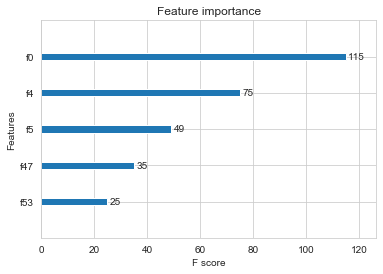

In [314]:
from xgboost import XGBClassifier, plot_importance
model = XGBClassifier()
model.fit(X_train,y_train)
sorted_idx = np.argsort(model.feature_importances_)[::-1]
for index in sorted_idx:
    print([X.columns[index], model.feature_importances_[index]]) 
plot_importance(model, max_num_features = 5)
plt.show()

In [96]:
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
scoring = 'roc_auc'
models = []

models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('XGB', XGBClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('SGD', SGDClassifier()))
models.append(('RF', RandomForestClassifier(n_jobs=-1)))


kfold = model_selection.KFold(n_splits=10, random_state=123)
results = []
names = []
for name, model in models:
   
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


LR: 0.729668 (0.011462)
LDA: 0.729209 (0.011565)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


KNN: 0.687918 (0.014762)
CART: 0.729293 (0.009481)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


NB: 0.747224 (0.012171)
XGB: 0.765234 (0.007869)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


GB: 0.764996 (0.007979)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


SGD: 0.708726 (0.034932)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


RF: 0.741176 (0.008144)


### analysis for people from other countries working in USA

In [205]:
other_df.shape

(3391, 15)

In [206]:
other_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 4 to 32553
Data columns (total 15 columns):
age               3391 non-null int64
workclass         3391 non-null object
fnlwgt            3391 non-null int64
education         3391 non-null object
education_num     3391 non-null int64
marital_status    3391 non-null object
occupation        3391 non-null object
relationship      3391 non-null object
race              3391 non-null object
sex               3391 non-null object
capital_gain      3391 non-null int64
capital_loss      3391 non-null int64
hours_per_week    3391 non-null int64
native_country    3391 non-null object
sal               3391 non-null object
dtypes: int64(6), object(9)
memory usage: 423.9+ KB


In [211]:
#this might be a candidate for imputation ?

print("Percentage of Null values in Native-country -{0:.2f}%".format((len((other_df[other_df['native_country']=='?']))/len(other_df['native_country']))*100))


percentage of Null values in workclass feature - 0.00%
Percentage of Null values in occupation feature - 0.00%
Percentage of Null values in Native-country -17.19%


In [222]:
other_df['native_country'].replace({'?':"others"},inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6786: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [228]:
other_df['workclass'].replace({'?':"others"},inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6786: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [223]:
other_df['native_country'].unique()

array(['Cuba', 'Jamaica', 'India', 'others', 'Mexico', 'South',
       'Puerto-Rico', 'Honduras', 'England', 'Canada', 'Germany', 'Iran',
       'Philippines', 'Italy', 'Poland', 'Columbia', 'Cambodia',
       'Thailand', 'Ecuador', 'Laos', 'Taiwan', 'Haiti', 'Portugal',
       'Dominican-Republic', 'El-Salvador', 'France', 'Guatemala',
       'China', 'Japan', 'Yugoslavia', 'Peru',
       'Outlying-US(Guam-USVI-etc)', 'Scotland', 'Trinadad&Tobago',
       'Greece', 'Nicaragua', 'Vietnam', 'Hong', 'Ireland', 'Hungary',
       'Holand-Netherlands'], dtype=object)

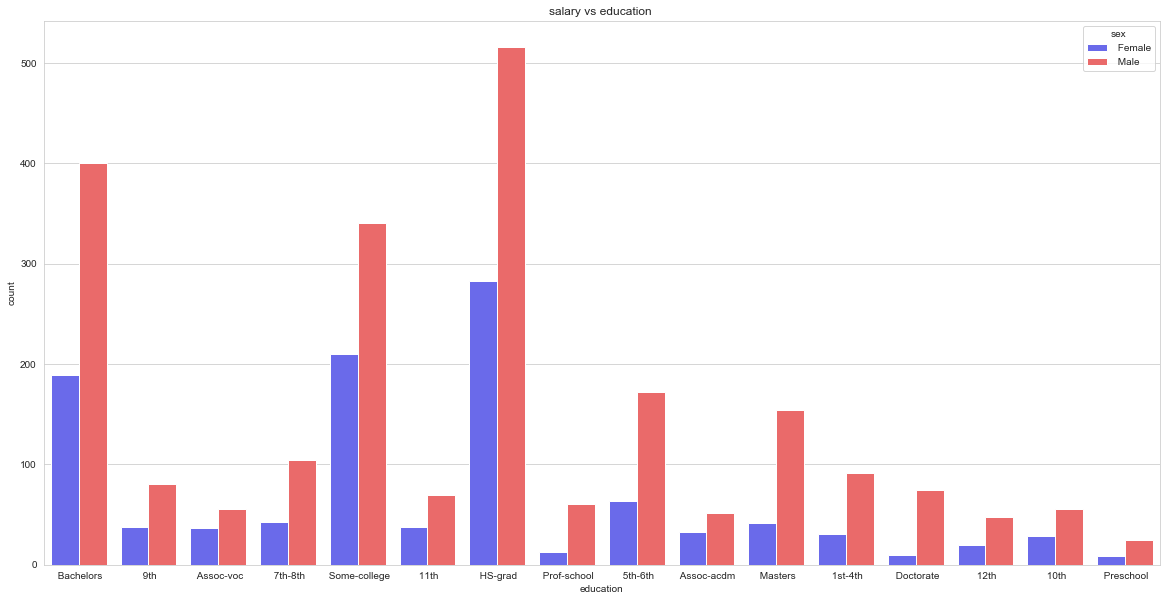

In [226]:
plt.figure(figsize=(20,10))
plt.title('salary vs education ')
sns.countplot(x='education',data=other_df,hue='sex',palette='seismic')

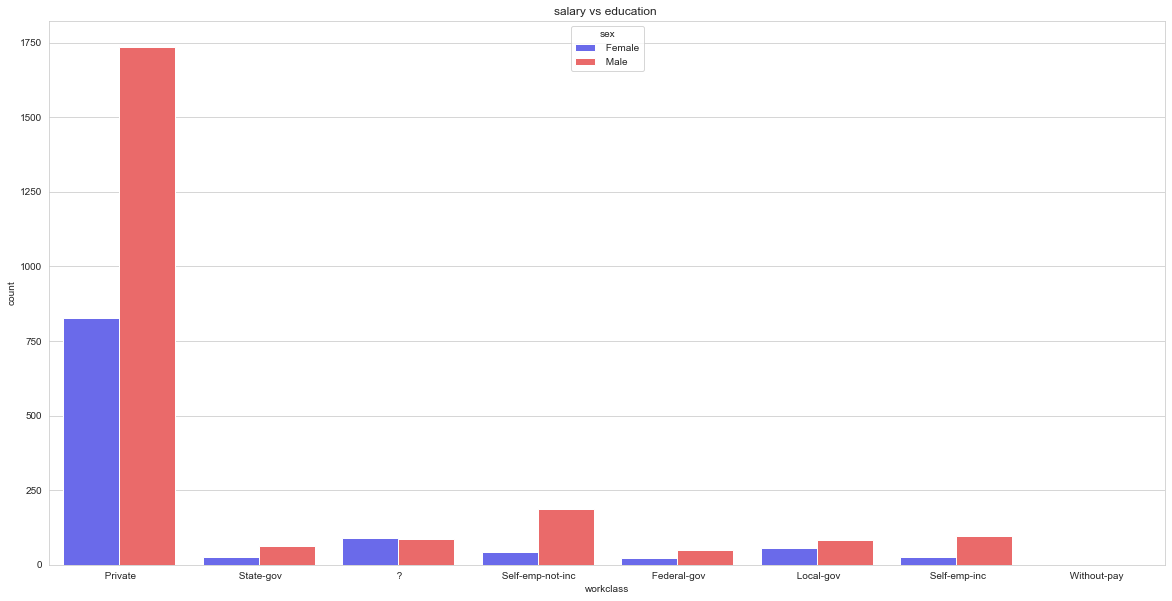

In [230]:
plt.figure(figsize=(20,10))
plt.title('salary vs education ')
sns.countplot(x='workclass',data=other_df,hue='sex',palette='seismic')

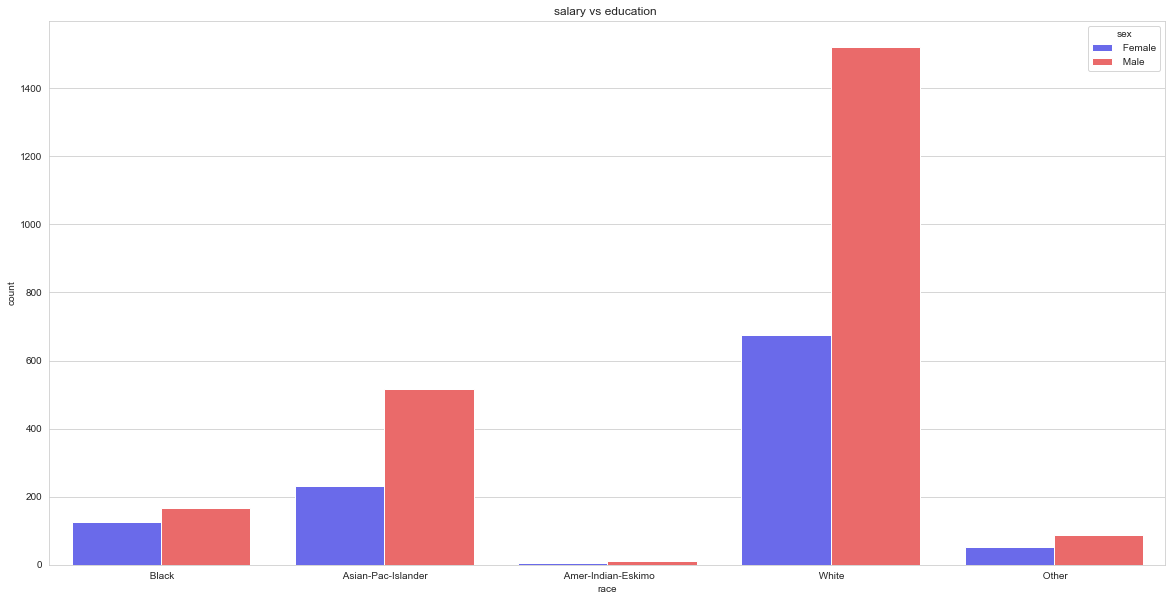

In [231]:
plt.figure(figsize=(20,10))
plt.title('salary vs education ')
sns.countplot(x='race',data=other_df,hue='sex',palette='seismic')

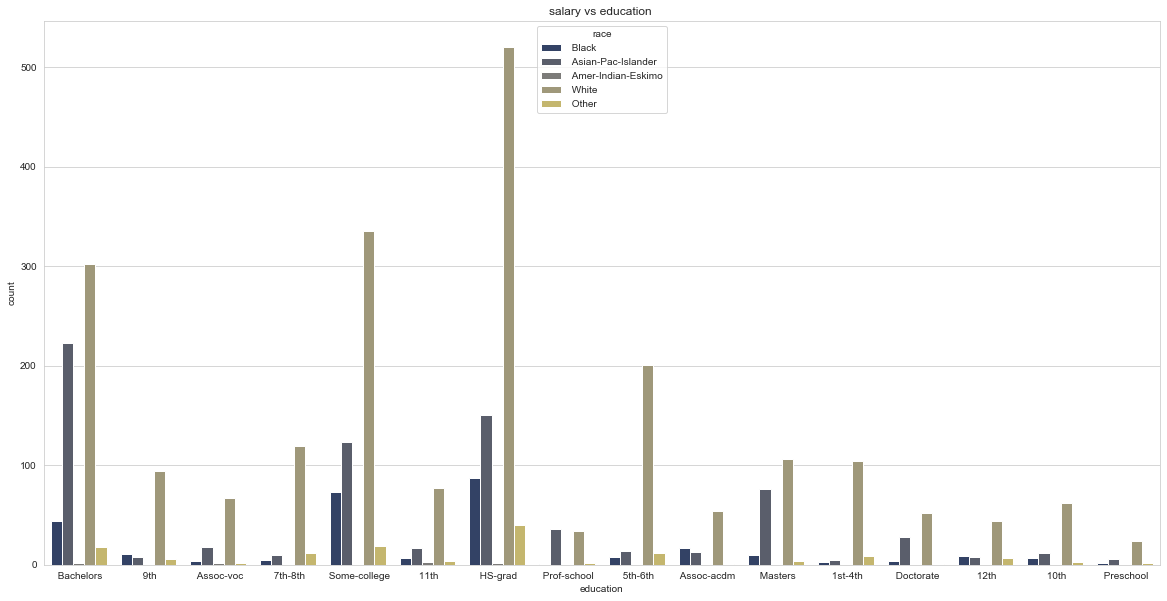

In [234]:
plt.figure(figsize=(20,10))
plt.title('salary vs education ')
sns.countplot(x='education',data=other_df,hue='race',palette='cividis')

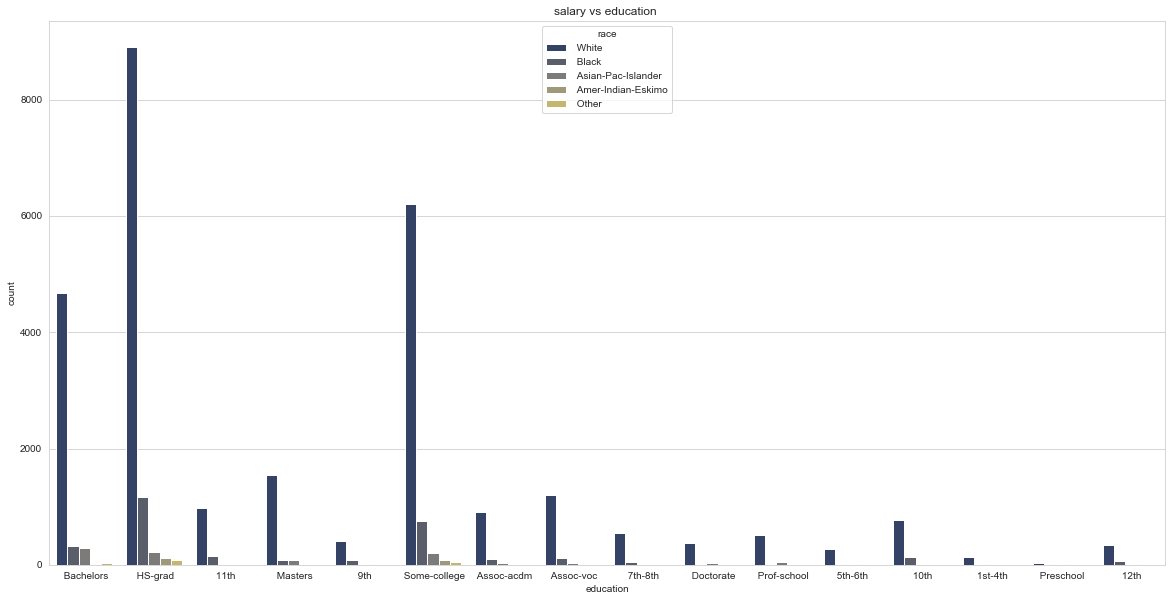

In [236]:
plt.figure(figsize=(20,10))
plt.title('salary vs education ')
sns.countplot(x='education',data=raw_df,hue='race',palette='cividis')